In [2]:
from pathlib import Path

import matplotlib as mpl
import polars as pl
import seaborn as sns
from atollgen_cli.runner import DataHolder
from entrez_fetcher.genome_store import GenomeStore
from matplotlib import pyplot as plt
from scibelt.aggregates import Dataset, aggregate_format, format_data
from scibelt.viz import (
    FigureSaver,
    get_legend_hl,
    seqlen_plot,
    propbarplot,
    alias_or_name,
    latex_size,
)
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind


In [3]:
data_holder = DataHolder(Path("../data/interim/"), ensure_data=False)
adb_path = data_holder.db_dir / "adb"
adb_sources_dir = data_holder.db_dir / "sources"
genome_store_dir = data_holder.db_dir / "genomes"
genome_store = GenomeStore(genome_store_dir)

ds = Dataset.from_folder(
    "../data/post-process/base_nooverlaps/", genome_store=genome_store
)

abbr_phyl = {
    "Pseudomonadota oth.": "Pseudo. oth.",
    "Xanthomonadales γp.": "Xantho. γp.",
    "Vibrionales γp.": "Vibrio. γp.",
    "Pseudomonadales γp.": "Pseudo.γp.",
    "Enterobacterales γp.": "Entero. γp.",
    "Bacillota": "Bacillo.",
    "Actinomycetota": "Actino.",
    "Bacteroidota": "Bactero.",
}

fs = FigureSaver("../figures/main/fig02")

In [4]:
seqlens = ds.islands.select("label", "seq_len")

colors_phylum = {
    info.get("alias", name): info["color"]
    for name, info in format_data["phylum_8"].items()
}

filt_islands = ds.islands.join(ds.phylum, on="index")
filt_islands = aggregate_format(filt_islands, index="phylum", index_key="phylum")
filt_islands = filt_islands.filter(
    pl.col("phylum").is_in(alias_or_name(format_data["phylum_8"]))
    & pl.col("label").is_in(["IE", "ICE", "IME"])
)


In [5]:
data = {}
to_test = filt_islands.to_pandas()
for label, df in to_test.groupby("label"):
    ref = df.query("phylum == 'Bacillota'").seq_len
    for (phylum, subdf) in df.groupby("phylum"):
        ttest = ttest_ind(np.log(subdf["seq_len"]), np.log(ref), equal_var=False)
        data[(label, phylum)] = {"t": ttest.statistic, "pvalue": ttest.pvalue}

df = pd.DataFrame(data)
df = df.unstack()
df = df.unstack(1).dropna(how="all", axis=1).dropna(how="all").T

pvalues = df.xs("pvalue", level=1, axis=1)
cfs = pvalues.copy()
cfs[:] = "ns"
for i, confidence in enumerate([0.05, 0.01, 0.001], 1):
    cfs = cfs.where(pvalues > confidence, i * "*")
cfs.loc["Bacillota"] = ""
cfs

ICE   IE  IME
Actinomycetota         ns  ***   ns
Bacillota                          
Bacteroidota          ***  ***   ns
Enterobacterales γp.  ***  ***   **
Pseudomonadales γp.   ***  ***  ***
Pseudomonadota        ***  ***   ns
Vibrionales γp.       ***  ***    *
Xanthomonadales γp.   ***  ***    *

In [10]:
# Panel A

with latex_size(double=False, fontsize=6, ratio=2.3):
    fig, ax = plt.subplots()
    seqlen_plot(
        seqlens.filter(pl.col("label") != "psiICE").to_pandas(),
        "label",
        ax=ax,
    )
    ax.set_yticks(np.arange(0, 305e3, 50e3))
    ax.set_ylim(0, 305e3)
    ax.set_xlabel("")
fs.savefig(fig, "panel_A")

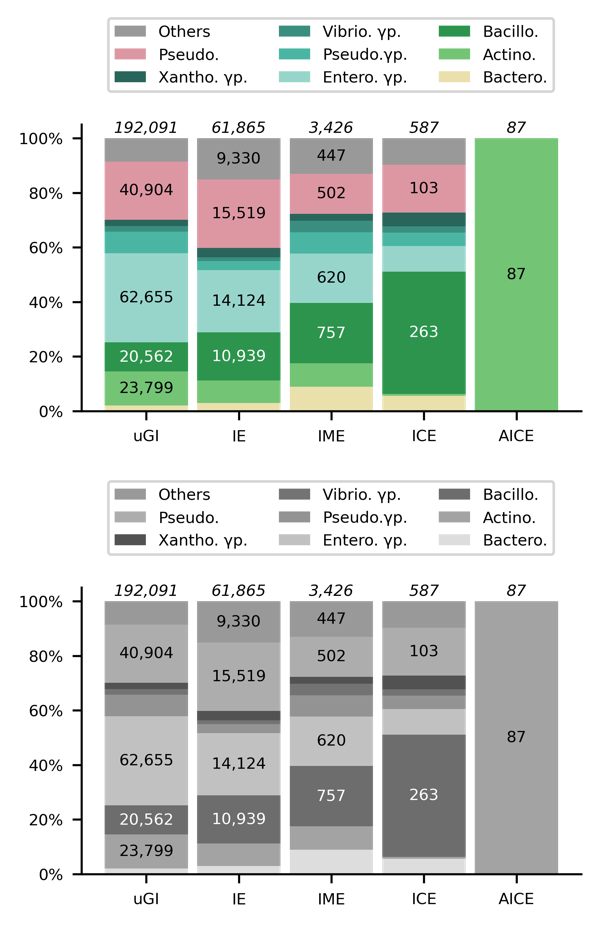

In [7]:
# Panel B

df = aggregate_format(
    ds.phylum8_by_label, index="phylum", columns="label", index_key="phylum_8"
)
df = df.drop("ψICE")

with latex_size(double=False, fontsize=6):
    fig, ax = plt.subplots()
    propbarplot(
        df.to_pandas().set_index("phylum").T,
        ax=ax,
        color=colors_phylum,
        legend=False,
        kind="bar",
    )
    handles, labels = get_legend_hl(ax)
    labels = [abbr_phyl.get(label, label) for label in labels]
    legend = fig.legend(
        handles, labels,
        ncol=3,
        loc="lower center",
        bbox_to_anchor=(0.0, 1, 1.1, 0.102),
        borderaxespad=0.0,
    )
    ax.grid(False)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_xlabel("")
fig.tight_layout()
fs.savefig(fig, "panel_B")


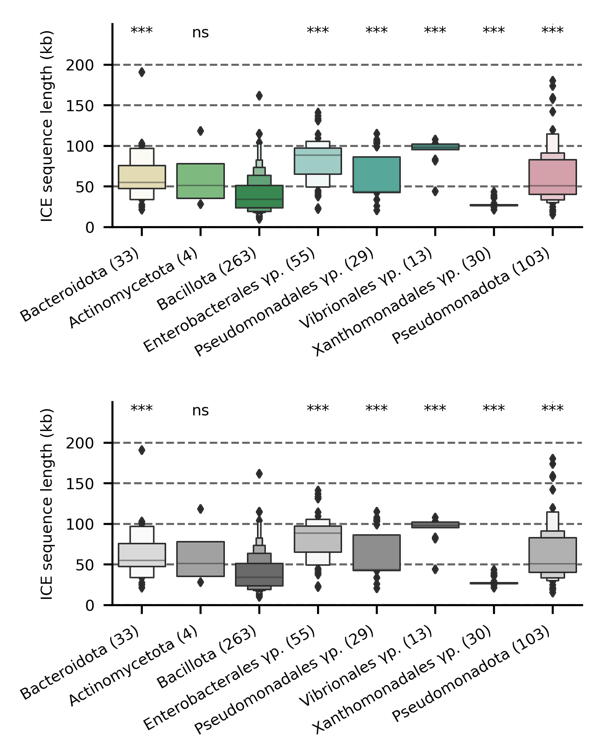

In [8]:
# Panel C

with latex_size(double=False, fontsize=6, ratio=2.3):
    fig, ax = plt.subplots()
    seqlen_plot(
        filt_islands.filter(pl.col("label") == "ICE").to_pandas(),
        "phylum",
        on_key="phylum_8",
        reverse_order=False,
        ax=ax,
    )
    ax.set_xticklabels(
        [" ".join(label.get_text().split("\n")) for label in ax.get_xticklabels()],
        rotation=30,
        ha="right",
    )
    ax.set_ylim(0, 250e3)
    yfact = ax.get_ylim()[1] * 0.05

    for i, phylum in enumerate(alias_or_name(format_data["phylum_8"])):
        if phylum == "Others":
            continue
        cf = cfs.loc[phylum.split("\n")[0], "ICE"]
        y = min(
            subdf[subdf.phylum == phylum].seq_len.max() + yfact,
            ax.get_ylim()[1] - yfact,
        )
        ax.text(
            i,
            230e3,
            f"{cf}",
            horizontalalignment="center",
            verticalalignment="bottom",
        )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
    # more major ticks
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(50e3))
    yticks = ax.yaxis.get_major_ticks()
    yticks[-2].set_visible(False)
    ax.set_axisbelow(True)
    ax.set_xlabel("")
    ax.set_ylabel("ICE sequence length (kb)")

fs.savefig(fig, "panel_C")
